# ***深度学习入门：基于python的理论和实践***

## ***第六章：与学习相关的技巧***

第六章针对于神经网络中的**机器学习部分**，涉及寻找最优权重参数、初始参数、超参数和权值衰减、$Dropout$等正则化方法应对过拟合

### **6.1参数的更新**

参数的更新是为了损失函数的值更小，达到**最优化**$（optimization）$,随机梯度下降算法$（stochastic \space gradient \space descent）$是其中一种最优化方法

但是由于$SGD$存在缺陷，因此可以采用$Momentum$、$AdaGrad$、$Adam$等优化算法

### **6.1.1 探险家的故事**

原文中探险家到达“至深之地”的过程对应着$SGD$优化参数的过程<br>其中第一条规则是‘要找到最低点’这一目的<br>第二条规则是无法了解损失函数全局的样貌，由此可见$SGD$是一种寻找局部最优解的方法，梯度(方向)是$SGD$的决定因素

### **6.1.2 $SGD$**

$SGD$更新参数的过程$\rightarrow$

$$W^{t+1}\leftarrow W^{t}-\eta \frac{\partial L}{\partial W}$$

其中$\eta$为学习率，是一个超参数，需要预先设定

用$Python$定义一个$SGD$的类$\rightarrow$

In [1]:
"""
Created on Thu May  5 16:09:56 2022

@author: wangchen
"""
class SGD:
    def __init__(self,lr=0.01):
        self.lr=lr
    def update(self,params,grads):
        for keys in params:
            params[keys]-=self.lr*grads[keys]

$SGD$应用于$mini-batch$中$\rightarrow$

In [1]:
import numpy as np
from mnist import load_mnist#正规化数据集
from two_layer_net import TwoLayerNet#导入框架

class SGD:
    def __init__(self,lr=0.01):
        self.lr=lr
    def update(self,params,grads):
        for keys in params:
            params[keys]-=self.lr*grads[keys]
(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,one_hot_label=True)
#正规化训练数据集，测试数据集以one-hot编码形式出现
#==============================================================================
#设置超参数->需要认为设定的参数
train_loss_list=[]#记录每次训练的损失
iters_num=10000#训练次数
train_size=x_train.shape[0]#训练数据的大小
batch_size=100#每次训练所抽取的样本数量
learning_rate=0.1#学习率
optimizer = SGD()
#==============================================================================
network=TwoLayerNet(input_size=784, hidden_size=50, output_size=10)#实例化TwolayerNet类
#784=28×28对应一副图像的大小，10对应的是0-9个数字
for i in range(iters_num):
    batch_mask=np.random.choice(train_size,batch_size)#从train_size选取batch_size个样本
    x_batch=x_train[batch_mask]#批抽取数据
    t_batch=t_train[batch_mask]#批抽取对应数据的监督数据
#==============================================================================
    grad=network.numerical_gradient(x_batch, t_batch)#在TwolayerNet中完成前向推理和计算梯度
#================================================================================
#计算完梯度后便是梯度下降和迭代过程
    params=network.params
    grads=network.gradient(x_batch, t_batch)
    optimizer.update(params, grads)
    loss=network.loss(x_batch, t_batch)#计算损失
    train_loss_list.append(loss)#加入损失字典中
#TwolayerNet中的param和grad都是存储权重和梯度的字典
#直到i==iters_num时才停止更新过程，这里更新了10000次
#=================================================


ModuleNotFoundError: No module named 'mnist'

其中最优化的层用**$optimizer$**表示,同理用$Momentum$层用$optimizer=\space Momentum()$表示

### **6.1.3 $SGD$的缺点**

$SGD$最本质的缺点在于更新参数时依赖局部梯度，因此对于全局优化效率较低

例如对于空间曲面$f(x,y)=x^{2}+y^{2}$

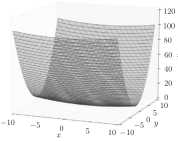

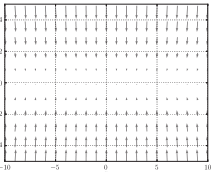

图中箭头所指的方向为该点处的**梯度方向**，可以看出只有很少一部分的箭头指向$(0,0)$处

所以在$SGD$在寻找最优解时的**路径**是这样$\rightarrow$

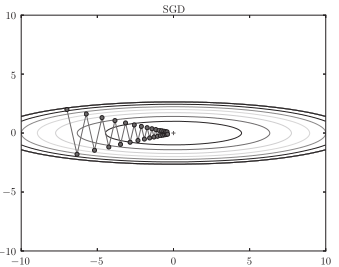

因为$SGD$在寻找最优解时，梯度的方向总是大致沿着$y$的方向，所以搜寻的**效率较低**

### **6.1.4 $Momentum$**

$Momentum$是“动量”的意思，算法具有物理意义

$$v^{t+1}\leftarrow \alpha v^{t}-\eta \frac{\partial L}{\partial W^{t}}$$

$$W^{t+1}\leftarrow W^{t}+v^{t+1}$$

$Momentum$与$SGD$相同之处在于$W$是要更新的参数<br><br>
不同之处在于$Momentum$中$v$是速度，$\eta \frac{\partial L}{\partial W}$是梯度上的力，$\alpha$是自然阻力

这个过程类似于一个小球在合力的作用下(梯度)在曲面上滚动

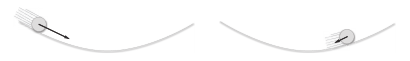

$Momentum$的代码实现$\rightarrow$

In [ ]:
"""
Created on Thu May  5 16:09:56 2022

@author: wangchen
"""
import numpy as np
class Momentum:
    def __init__(self,lr=0.01,momentum=0.9):
        self.lr=lr
        self.momentum=momentum
        self.v=None
    def update(self,params,grads):
        if self.v==None:
            v={}
            for key,val in params.item():
                self.v[key]=np.zeros_like(val)#创建一个与params同样大小的零字典
        for keys in params:
            self.v[keys]=self.momentum*self.v[keys]-self.lr*grads[keys]
            params[keys]+=self.v[keys]

$Momentum$搜寻$f(x,y)=x^{2}+y^{2}$最小值的过程$\rightarrow$

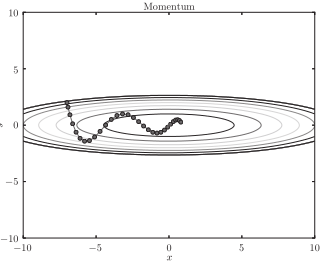

$Momentum$算法因为其物理意义，相比于$SGD$弯的个数更少，因此效率比$SGD$高

### **6.1.5$AdaGrad$**

$AdaGrad$算法在更新参数的过程中会记录每次梯度的平方和，算法中的变量$h$能够**调整**学习的尺度$learningrete$

$$h^{t+1}\leftarrow h^{t}+\frac{\partial L}{\partial W} \bigodot \frac{\partial L}{\partial W}$$

$$W^{t+1}\leftarrow W^{t}-\eta \frac{1}{\sqrt h}\frac{\partial L}{\partial W^{t}}$$

从公式中可以看出参数的元素中变动较大($\frac{\partial L}{\partial W} \bigodot \frac{\partial L}{\partial W}$越大)学习率将变小

$AdaGrad$的代码实现$\rightarrow$

In [ ]:
"""
Created on Thu May  5 22:02:57 2022

@author: qingchenweifeng
"""
import numpy as np
class AdaGrad:
    def __init__(self,lr=0.01):
        self.lr=lr
        self.h=None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)#防止出现0作为除数的情况

$AdaGrad$搜寻$f(x,y)=x^{2}+y^{2}$最小值的过程$\rightarrow$

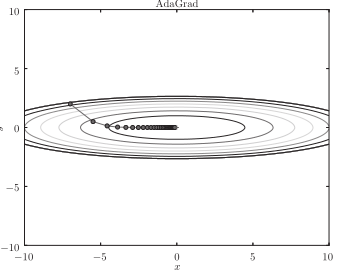

从图中可以看出$y$轴上的变动从大变小，这是由于$AdaGrad$算法调整$y$方向的更新过程

### **6.1.6$Adam$**

$Adam$算法是**结合**了$Momentum$和$AdaGrad$的方法，组合两者的优点，能够实现参数空间的高效搜索<br><br>$Adam$算法公式中含有学习率$\alpha$，一次$Momentum$系数$\beta _{1}$,二次$Momentum$系数$\beta _{2}$

$$\hat{m_{t}}=\frac{m_{t}}{1-(\beta _{1})^{t}}$$

$$\hat{v_{t}}=\frac{v_{t}}{1-(\beta _{2})^{t}}$$

$$W^{t}=W^{t-1}-\frac{\hat{m_{t}}}{\sqrt{\hat{v_{t}}}+\epsilon}$$

基于$Adam$最优化的更新路径$\rightarrow$

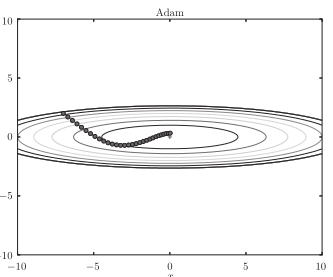

### **6.1.7 使用那种更新方法**

对于搜寻$f(x,y)=x^{2}+y^{2}$的最小值，基于$SGD$ $Momentum$ $AdaGrad$ $Adam$四种的算法$\rightarrow$

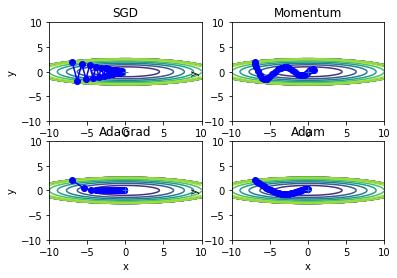

从中可以看出$AdaGrad$的效果是最好的，但是选取哪种方法需要根据实际问题和学习率的设定有关

### **6.1.8 基于Mnist数据集的更新方法的比较**

四种算法在$Mnist$数据集学习进展上的差异$\rightarrow$

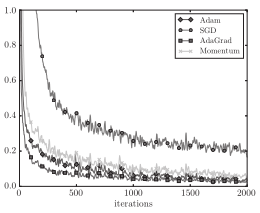

从结果中可以看出$AdaGrad$的学习率最快，$SGD$相比于其他算法较慢

### **6.2 权重的初始值**

权重的初始值往往**关系着神经网络的学习能否成功**

### **6.2.1 可以将初始权重设为0吗**

权值衰减($weight \space decay$)是一种**抑制过拟合现象**发生的办法，在实际过程中初始权重设定为不同的较小值
<br><br>如标准差为$0.01$的高斯分布

初始权重不能设为相同的值，这是为了**瓦解权重的对称结构**，如果初始权重均为0的话，在反向传播时所有的权重会进行相同的更新

### **6.2.2 隐藏层的激活值的分布**

隐藏层的激活值分布指的是每一层激活函数的输出数据分布

基于$Sigmoid$激活函数的激活值数据分布$\rightarrow$

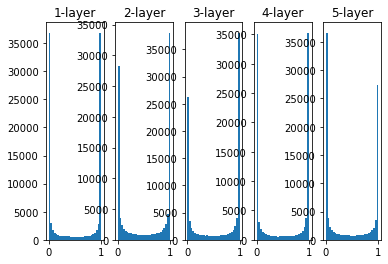

In [3]:
"""
Created on Fri May  6 16:45:38 2022

@author: qingchenweifeng
"""
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x=np.random.randn(1000,100)#1000个输入数据
node_num=100#100个结点
hidden_layer_size=5#5个隐藏层
activations={}#存储激活值

for i in range(hidden_layer_size):
    if i!=0:        
        x=activations[i-1]
    w=np.random.randn(node_num,node_num)*1#权重，标准差为1,每次循环均产生一次随机权重
    z=np.dot(x,w)
    a=sigmoid(z)
    activations[i]=a#记录一次激活分布

#绘制分布图
for i,a in activations.items():
    plt.subplot(1, len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

由图可以看出数据大部分集中在0和1，但是$Sigmoid$在0和1处的导数为0，所以在反向传播中这些权重的梯度会消失，即**梯度消失**$(gradient\space vanishing)$

为了**避免梯度消失**，把标准差换成0.01$\rightarrow$

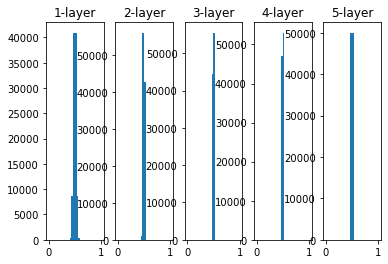

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x=np.random.randn(1000,100)#1000个输入数据
node_num=100#100个结点
hidden_layer_size=5#5个隐藏层
activations={}#存储激活值

for i in range(hidden_layer_size):
    if i!=0:        
        x=activations[i-1]
    w=np.random.randn(node_num,node_num)*0.01#权重，标准差改为0.01,每次循环均产生一次随机权重
    z=np.dot(x,w)
    a=sigmoid(z)
    activations[i]=a#记录一次激活分布

#绘制分布图
for i,a in activations.items():
    plt.subplot(1, len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

虽然避免了梯度消失，但是分布均在0.5处，表现力**单一**，神经元个数没太大意义，即 **“表现力受限”**

基于$Xiaver$初始值的激活分布$\rightarrow$

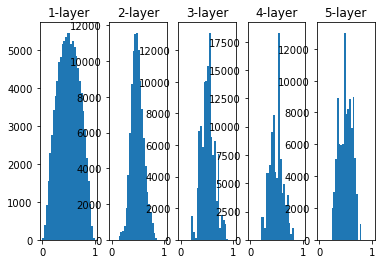

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x=np.random.randn(1000,100)#1000个输入数据
node_num=100#100个结点
hidden_layer_size=5#5个隐藏层
activations={}#存储激活值

for i in range(hidden_layer_size):
    if i!=0:        
        x=activations[i-1]
    w=np.random.randn(node_num,node_num)/np.sqrt(node_num)#Xiaver权重，标准差改为根号N,每次循环均产生一次随机权重
    z=np.dot(x,w)
    a=sigmoid(z)
    activations[i]=a#记录一次激活分布

#绘制分布图
for i,a in activations.items():
    plt.subplot(1, len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

激活函数$Sigmoid$换成$tan(X)$ $\rightarrow$

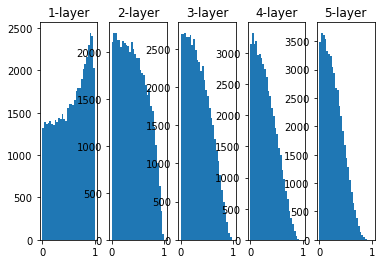

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x=np.random.randn(1000,100)#1000个输入数据
node_num=100#100个结点
hidden_layer_size=5#5个隐藏层
activations={}#存储激活值

for i in range(hidden_layer_size):
    if i!=0:        
        x=activations[i-1]
    w=np.random.randn(node_num,node_num)/np.sqrt(node_num)#Xiaver权重，标准差改为根号N,每次循环均产生一次随机权重
    z=np.dot(x,w)
    a=np.tanh(z)#换成tanh的激活函数
    activations[i]=a#记录一次激活分布

#绘制分布图
for i,a in activations.items():
    plt.subplot(1, len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

这样的激活输出分布**不再受限**，能够进行高效的学习

### **6.2.3 $ReLU$的权重初始值**

$ReLU$的权重初始值使用$He$初始值，是因为$ReLU$不同于$Sigmoid$和$tanh$

$He$的初始值使用的标准差为$\sqrt{\frac{2}{n}}$

使用基于$0.01$、$Xiaver$、$He$标准差的权重初始值下的分布$\rightarrow$

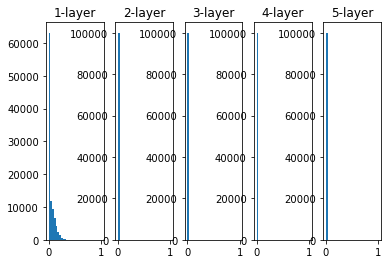

【标准差为$0.01$】激活值主要分布在0附近，说明反向传播时传递的**梯度值会很小**，会造成学习时没有太大的**进展**

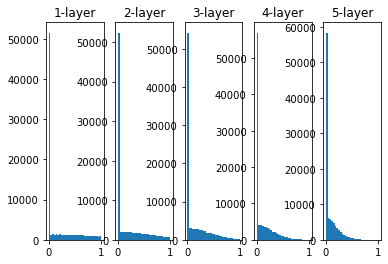

【标准差为$Xiaver$】随着层数的加深，峰值往左移，说明**偏向**越来越大，造成**梯度消失**

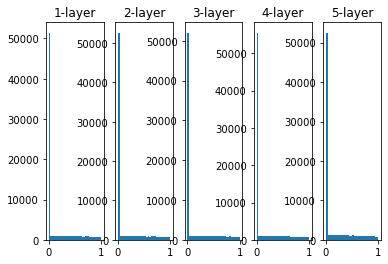

【标准差为$He$】随着层数的加深，数据**分布均匀**，在反向传播时能传递合理的值

### **6.3 $Batch \space Nomorliazation$**

$Batch \space Normorliazation$具有的优点：
<br>**·增大学习率
<br>·不过于依赖权重初始值
<br>·抑制过拟合**

$Batch \space Norm$算法的具体做法是使数据分布的均值为0、方差为1的**正规化**，接着对正规化后的数据进行**缩放和平移的变换**

$$\mu _{B}\leftarrow \frac{1}{m} \sum_{i=1}^{m}{x_{i}}$$

$$\sigma _{B}^{2}\leftarrow \frac{1}{m}\sum_{i=1}^{m}{(x_{i}-\mu _{B})^{2}}$$

$$\hat{x_{i}}\leftarrow \frac{x_{i}-\mu_{B}}{\sqrt{\sigma_{B}^{2}+\upsilon}}$$

$$y_{i}\leftarrow \gamma \hat{x}_{i} +\beta$$

其中$\mu _{B}$是**平均值**，$\sigma _{B}^{2}$为**方差**，初始$\gamma =1$，$\beta =0$，其后在学习中调整

$Batch \space Norm$层在计算图中的表示$\rightarrow$

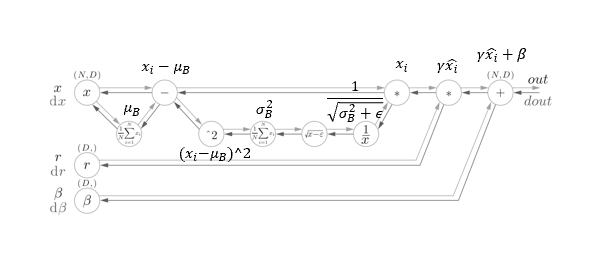

### **6.3.2$ Batch \space Normorliazation$的评估**

将$Batch\space Norm$插入隐藏层中，对比于没有插入$Batch\space Norm$层的精度比较$\rightarrow$

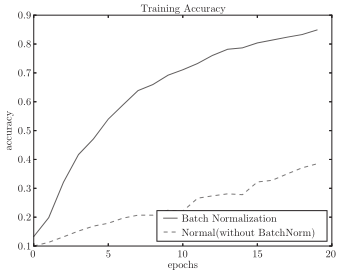

可以看出通过$Batch\space Norm$层**学习率大幅增加**，并且使得神经网络**不过多依赖于初始权重值**

进一步，$Batch\space Norm$在**不同标准差**$w$下学习中的精度$\rightarrow$

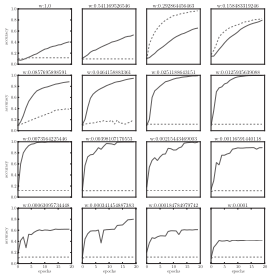

可以看出几乎在所有不同的标准差下，使用$Batch \space Norm$层精度具有很大的优势

### **6.4 正规化**

**过拟合**，指的是可以很好地拟合训练数据，但是会出现拟合其他测试数据时精度低的现象

### **6.4.1 过拟合**

出现过拟合的原因有$\Rightarrow$

 ·**参数**过多(神经元个数过多)，表现力强
  <br><br>
 ·**训练样本**过少

模拟$Mnist$数据集中的过拟合现象$\rightarrow$

In [ ]:
import numpy as np
from mnist import load_mnist
from multi_layer_net import MultiLayerNet
from optimizer import SGD
import matplotlib.pyplot as plt

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)
#只取300组训练数据
x_train=x_train[:300]
t_train=t_train[:300]
#导入框架
network=MultiLayerNet(input_size=784, hidden_size_list=[100,100,100,100,100,100], output_size=10)
#导入梯度下降(SGD)
optimizer=SGD(lr=0.01)

max_epochs=201
train_size=x_train.shape[0]
batch_size=100

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

#迭代次数
iter_per_epoch=max(train_size/batch_size,1)
epoch_cnt=0
#训练
for i in range(10000000):
    batch_mask=np.random.choice(train_size,batch_size)
    x_batch=x_train[batch_size]
    t_batch=t_train[batch_size]
    
    grads=network.gradient(x_batch, t_batch)#进行了正向传播且返回梯度字典
    #学习部分
    optimizer.update(network.params, grads)
    if i%iter_per_epoch==0:
        train_acc=network.accuracy(x_train, t_train)
        test_acc=network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
    #只训练max_epoch次
    epoch_cnt+=1
    if epoch_cnt>=max_epochs:
        break
#绘图
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

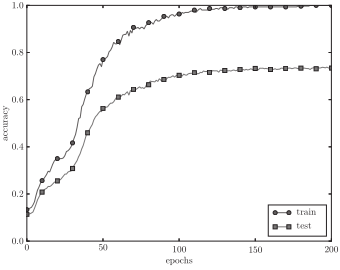

可以看出训练集的精确度随着$epoch$的增加而逐渐收敛于**1**，但是在测试集中的精确度收敛于**0.78**左右

### **6.4.2 权值衰减**

**权值衰减**是一种抑制过拟合的方法，因为有些权重参数过大，权值衰减将抑制这些权重

具体做法是将损失函数加上权重的平方范数，即$Loss+\frac{1}{2}\lambda W^{2}$,损失函数越大，对权重的抑制越强

将权值衰减应用于容易发生过拟合现象的神经网络中$\rightarrow$

In [ ]:
import numpy as np
from mnist import load_mnist
from multi_layer_net import MultiLayerNet
from optimizer import SGD
import matplotlib.pyplot as plt

weight_decay_lambda=0.1#加入了权值衰减,lambda=0.1
(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)
#只取300组训练数据
x_train=x_train[:300]
t_train=t_train[:300]
#导入框架
network=MultiLayerNet(input_size=784, hidden_size_list=[100,100,100,100,100,100], output_size=10,weight_decay_lambda=weight_decay_lambda)
#导入梯度下降(SGD)
optimizer=SGD(lr=0.01)

max_epochs=201
train_size=x_train.shape[0]
batch_size=100

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

#迭代次数
iter_per_epoch=max(train_size/batch_size,1)
epoch_cnt=0
#训练
for i in range(10000000):
    batch_mask=np.random.choice(train_size,batch_size)
    x_batch=x_train[batch_size]
    t_batch=t_train[batch_size]
    
    grads=network.gradient(x_batch, t_batch)#进行了正向传播且返回梯度字典
    #学习部分
    optimizer.update(network.params, grads)
    if i%iter_per_epoch==0:
        train_acc=network.accuracy(x_train, t_train)
        test_acc=network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
    #只训练max_epoch次
    epoch_cnt+=1
    if epoch_cnt>=max_epochs:
        break
#绘图
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)

plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

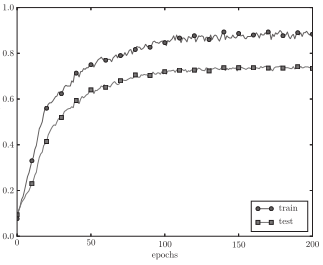

可以看出测试集和训练集的精度**差距变小**，说明权值衰减能够一定程度上**降低过拟合**

### **6.4.3 $Dropout$**

除了权值衰减，$Dropout$同样也能抑制过拟合现象。具体做法是，在**训练的过程**中随机删除隐藏层中的神经元，**在测试过程**将输出乘上删除的比例

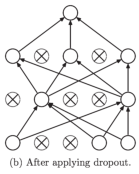

$Dropout$的代码实现$\rightarrow$

In [ ]:
import numpy as np
class Dropout:
    def __init__(self,dropout_ratio=0.5):
        self.dropout_ratio=dropout_ratio
        self.mask=None
    def forward(self,x,train_flg=True):
        if train_flg:
            self.mask=np.random.rand(*x.shape)>self.dropout_ratio#self.mask以False的形式保存要删除的神经元,值比ratio大的以True表示
            return x * self.mask
        else:
            return x*(1.0-self.dropout_ratio)
        def backward(self,dout):#被删除的神经元在反向传播时将不会被传递值
            return dout*self.mask

将$Dropout$运用在过拟合的神经网络中$\rightarrow$

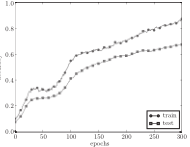

和权值衰减相通的是，测试集精度和训练集精度的差距也变小了，说明$Dropout$能降低过拟合。<br><br>但是当**神经网络模型变得复杂**的时候，使用$Dropout$比权值衰减更有效，$Dropout$是集成学习的再次“集成”

### **6.5 超参数的验证**

超参数($hyper-parameter$),是除权重、偏置等参数外需要人为设定的其他参数如神经元数量、$lr$、$batch$、$\lambda$

### **6.5.1 验证数据**

验证数据($validation\space data$)是专门**调整超参数**的数据集,因为若使用测试数据或训练数据，则会造成过拟合<br><br>
一般神经网络的**范式**:**训练数据**$\rightarrow$**验证数据**$\rightarrow$**测试数据** 

抽取出验证数据的过程$\rightarrow$


In [ ]:
from mnist import load_mnist
import numpy as np
from util import shuffle_dataset

(x_train,t_train),(x_test,t_test)=load_mnist()#导入数据
x_train,t_train=shuffle_dataset(x_train,t_train)#打乱数据

validation_rate=0.20#测试数据的占比
validation_num=int(x_train.shape[0]*validation_rate)

x_val=x_train[:validation_num]
t_val=t_train[:validation_num]
x_train=x_train[validation_num:]
t_train=t_train[validation_num:]

### **6.5.2 超参数的最优化**

**步骤0**:设定超参数的范围<br><br>
**步骤1**:从超参数范围中随机采样<br><br>
**步骤2**:使用选中的超参数进行学习，用验证数据评估精度(使用小$epoch$)<br><br>
**步骤3**:重复步骤1、2，缩小超参数的范围

以上是**基于实践方法**的最优化，还可以运用贝叶斯最优化($Bayesian\space optimization$)

贝叶斯最优化中采集方法$Acquisition\space Function$(针对步骤1)之一$\rightarrow$

$$PI(x)=P(f(x)\geq f(x^{+})+\nu)=\Phi (\frac{\mu (x)-f(x^{+})-\nu)}{\sigma (x)})$$

其原理就是找到未知点的函数值比$f(x^{+})$大的概率的点，并取这些点中概率最大的点,$Z-scores$标准化法可比较未知点的概率

### **6.5.3 参数最优化的实现**

使用$Mnist$数据集以**权值衰减**和**学习率**为对象进行最优化$\rightarrow$

In [ ]:
#这块是书上第六章的源码
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from multi_layer_net import MultiLayerNet
from util import shuffle_dataset
from trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了实现高速化，减少训练数据
x_train = x_train[:500]
t_train = t_train[:500]

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list#测试集精度，训练集精度


# 超参数的随机搜索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 指定搜索的超参数的范围===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

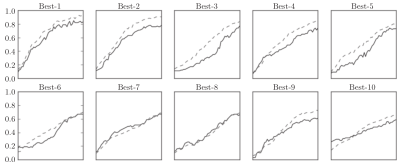

从图中可以看出$Best1-5$学习较顺利(结果收敛到较好的值),因此把**范围缩小**到$Best1-5$的权值和学习率

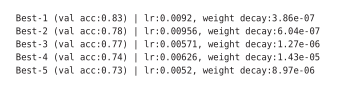

因此把权值和学习率的范围缩小到$lr:0.001-0.01\space\space weight\space decay:10^{-8}-10^{-6}$，接着再重复步骤1、2

### **6.6 小结**

• 参数的更新方法，除了SGD之外，还有Momentum、AdaGrad、Adam等方法。使用的方法根据实际问题而定<br><br>
• 权重初始值的赋值方法对进行正确的学习非常重要。比如标准差的设定会影响学习过程<br><br>
• 作为权重初始值，Xavier初始值、He初始值等比较有效。<br><br>
• 通过使用Batch Normalization，可以加速学习，并且对初始值变得健壮(不过于依赖初始值)。<br><br>
• 抑制过拟合的正则化技术有权值衰减、Dropout(适用于复杂模型)等。<br><br>
• 逐渐缩小“好值”存在的范围是搜索超参数的一个有效方法。